In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
import sys; sys.path.insert(0, '../')
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import pearsonr
import mne
from esinet import Simulation
from esinet.forward import get_info, create_forward_model
from esinet.util import unpack_fwd
pp = dict(surface='white', hemi='both')

In [2]:
info = get_info(kind='biosemi128')
fwd = create_forward_model(info=info, sampling='ico3')

leadfield, pos = unpack_fwd(fwd)[1:3]
n_chans, n_dipoles = leadfield.shape

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    2.8s remaining:    2.8s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.0s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    3.0s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.1s remaining:    0.1s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.2s finished
[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   2 out of   4 | elapsed:    0.3s remaining:    0.3s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s remaining:    0.0s
[Parallel(n_jobs=4)]: Done   4 out of   4 | elapsed:    0.3s finished


# Simulate

-- number of adjacent vertices : 1284
Simulating data based on sparse patches.


100%|██████████| 2/2 [00:00<00:00, 2006.36it/s]


source data shape:  (1284, 100) (1284, 100)


100%|██████████| 2/2 [00:00<00:00, 52.77it/s]

Using control points [0.         0.         0.44546054]


For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
Created an SSP operator (subspace dimension = 1)
1 projection items activated
SSP projectors applied...


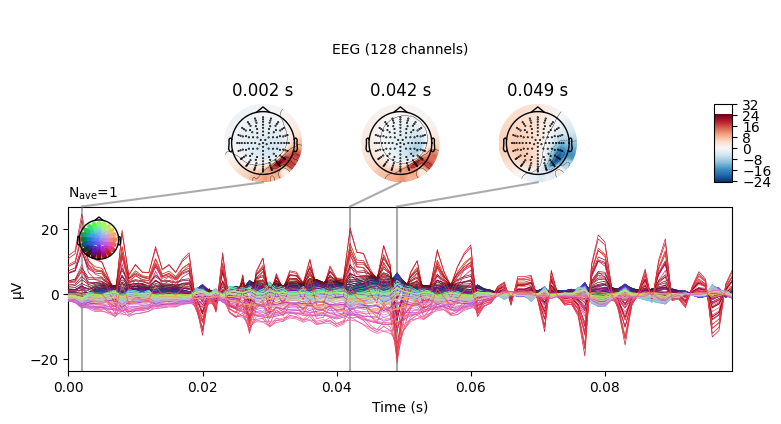

In [15]:
settings = dict(number_of_sources=3, extents=(1, 2), duration_of_trial=0.1, target_snr=1e99)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()

stc.data /= abs(stc.data).max()
brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)
evoked.plot_joint()

# Solve

Using control points [0.         0.         0.44259711]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
No projector specified for this dataset. Please consider the method self.add_proj.


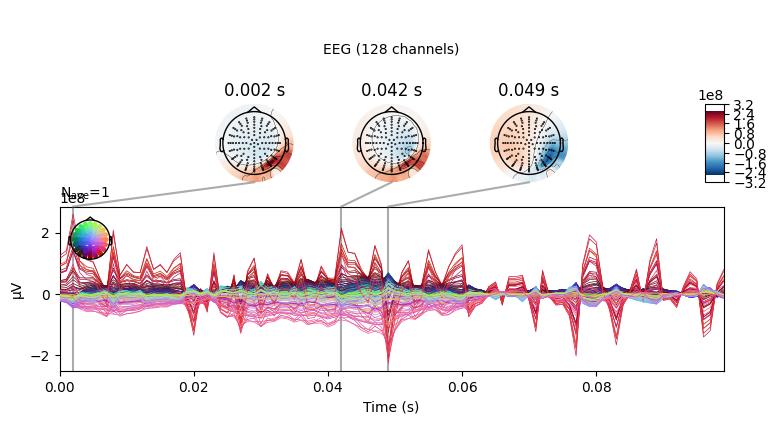

In [16]:
from invert import Solver
solver = Solver("SSMP")
solver.make_inverse_operator(fwd, evoked)
stc_ = solver.apply_inverse_operator(evoked)
stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info)
evoked_.plot_joint()

c:\Users\Lukas\Documents\projects\invert\dev\..\invert\solvers\base.py:109: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  evoked.set_eeg_reference("average", projection=True, verbose=0).apply_proj(verbose=0)


Using control points [0.01867773 0.02996433 0.34380277]
For automatic theme detection, "darkdetect" has to be installed! You can install it with `pip install darkdetect`
To use light mode, "qdarkstyle" has to be installed! You can install it with `pip install qdarkstyle`
No projector specified for this dataset. Please consider the method self.add_proj.


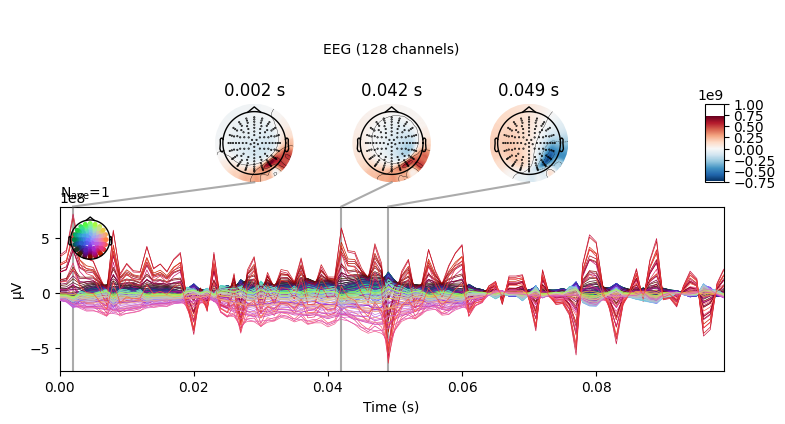

Using control points [0.         0.         0.15656531]
Using control points [0.         0.         0.16417956]
Using control points [0.0074823  0.01133817 0.02950672]
Using control points [0.         0.         0.08337255]
Using control points [0.03155312 0.04596158 0.29923016]
Using control points [0.         0.         0.49003122]


In [17]:
from invert import Solver
solver = Solver("eLORETA")
solver.make_inverse_operator(fwd, evoked)
stc_ = solver.apply_inverse_operator(evoked)
stc_.data /= abs(stc_.data).max()
brain = stc_.plot(**pp)
brain.add_text(0.1, 0.9, solver.name, 'title',
               font_size=14)

evoked_ = mne.EvokedArray(fwd["sol"]["data"] @ stc_.data, info)
evoked_.plot_joint()

# Big Loop

In [ ]:
from invert import Solver
# from invert.config import all_solvers
from invert.evaluate import nmse, corr, eval_mean_localization_error, eval_auc
from invert.adapters import contextualize_bd
import pickle as pkl

# if "LUCAS" in all_solvers:
#     all_solvers.remove("LUCAS")
# # if "Multiple Sparse Priors" in all_solvers:
# #     all_solvers.remove("Multiple Sparse Priors")
# if "Backus-Gilbert" in all_solvers:
#     all_solvers.remove("Backus-Gilbert")
# if "Fully-Connected" in all_solvers:
#     all_solvers.remove("Fully-Connected")

all_solvers = [ "SOMP", "SSMP", "MNE", "dSPM", "LORETA", "eLORETA", "Bayesian Beamformer LORETA", "Fully-Connected"]
settings = dict(number_of_sources=(1,15), extents=(1, 25), duration_of_trial=0.1, target_snr=1e99)
errors_corr = {sname: [] for sname in all_solvers}
errors_mle = {sname: [] for sname in all_solvers}
errors_auc = {sname: [] for sname in all_solvers}

solvers = dict()

for i in range(100):
    print(i)
    sim = Simulation(fwd, info, settings).simulate(2)
    stc = sim.source_data[0]
    evoked = sim.eeg_data[0].average()

    for solver_name in all_solvers:
        print(solver_name)
        solver = Solver(solver=solver_name)
        if (not solver_name in solvers):
            solvers[solver_name] = solver.make_inverse_operator(fwd, evoked, alpha="auto")
        stc_hat = solvers[solver_name].apply_inverse_operator(evoked)
        # stc_hat.plot(**pp, brain_kwargs=dict(title=solver.name))
        # error = np.mean(corr(stc.data, stc_hat.data))
        
        error_corr = np.mean(corr(stc.data, stc_hat.data))
        try:
            error_mle = eval_mean_localization_error(stc.data[:, 0], stc_hat.data[:, 0], pos)
        except:
            error_mle = np.nan
        error_auc = eval_auc(stc.data[:, 0], stc_hat.data[:, 0], pos)

        errors_corr[solver_name].append( error_corr )
        errors_mle[solver_name].append( error_mle )
        errors_auc[solver_name].append( error_auc )
        # print(error_corr, error_mle, error_auc)
    
    # print("Saving errors")
    # fn = "errors.pkl"
    # with open(fn, 'wb') as f:
    #     pkl.dump(errors, f)

In [ ]:
# import pickle as pkl
# fn = "errors.pkl"
# with open(fn, 'rb') as f:
#     errors = pkl.load(f)

In [13]:
import pandas as pd
import seaborn as sns
sns.set(font_scale=0.8)
df = pd.DataFrame(errors_corr)
sorted_index = df.median().sort_values().index
df = df[sorted_index]

plt.figure()
sns.boxplot(data=df)
plt.title("Correlation with ground truth")


df_mean_var = pd.concat([df.mean(), df.std()], axis=1)
df_mean_var = df_mean_var.rename(columns={0: "Median", 1: "Variance"})
df_mean_var["MedVar"] = df_mean_var["Median"] / df_mean_var["Variance"]
df_mean_var["Method"] = df_mean_var.index
display(df_mean_var)

plt.figure()
sns.scatterplot(x="Median", y="Variance", hue="Method", size="MedVar", data=df_mean_var)
plt.xlabel("Median")
plt.ylabel("Variance")


,Median,Variance,MedVar,Method
LORETA,0.095276,0.089893,1.059871,LORETA
dSPM,0.104020,0.028847,3.605874,dSPM
Fully-Connected,0.157547,0.106247,1.482842,Fully-Connected
Bayesian Beamformer LORETA,0.237022,0.192219,1.233084,Bayesian Beamformer LORETA
SSMP,0.394692,0.399243,0.988601,SSMP
SOMP,0.376859,0.398665,0.945301,SOMP
MNE,0.233163,0.101893,2.288299,MNE
eLORETA,0.286262,0.095138,3.008908,eLORETA


Text(0, 0.5, 'Variance')

In [ ]:
df

In [ ]:
settings = dict(number_of_sources=3, extents=(25, 35), duration_of_trial=0.025, target_snr=99999)

sim = Simulation(fwd, info, settings).simulate(2)
stc = sim.source_data[0]
evoked = sim.eeg_data[0].average()

brain = stc.plot(**pp)
brain.add_text(0.1, 0.9, 'Ground Truth', 'title',
               font_size=14)

In [ ]:
# from invert.solvers.empirical_bayes import SolverChampagne
# from invert.solvers.esinet import SolverFullyConnected
# solver_fc = SolverFullyConnected().make_inverse_operator(fwd, evoked)
# solver_ch = SolverChampagne().make_inverse_operator(fwd, evoked)
from invert.evaluate import nmse, corr

stc_hat = solver_ch.apply_inverse_operator(evoked)
stc_hat.plot(**pp)
# brain.add_text(0.1, 0.9, "Champagne", 'title',
#                font_size=14)
error_ch = np.mean(corr(abs(stc.data), abs(stc_hat.data)))

stc_hat = solver_fc.apply_inverse_operator(evoked)
stc_hat.plot(**pp)
# brain.add_text(0.1, 0.9, "Fully-Connected", 'title',
#                font_size=14)
error_fc = np.mean(corr(abs(stc.data), abs(stc_hat.data)))

print(f"Champ: {error_ch}\nFC: {error_fc}")